In [27]:
import numpy as np
import pandas as pd
from fractions import Fraction
from math import floor, gcd, log
import math
from qiskit import transpile
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from dotenv import load_dotenv
import os

In [19]:
def ModularExponentiation(power):
    """
    This function does modular exponentiation (a^r mod N) Given N = 15, and A is any coprime to N, so A = {2,4,7,11,13,14}, I chose here 2
    so this is the hard coded exponentiation for it.
    """
    U  = QuantumCircuit(4)
    for i in range(power): 
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
    U = U.to_gate()
    U.name = "Uf"
    cu = U.control()
    return cu

In [20]:
def QFTdagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)),m,j)
        qc.h(j)
    qc.name = "QFT Dagger"
    return qc

In [21]:
Qubits = 8
qc = QuantumCircuit(Qubits+4, Qubits)

for i in range(Qubits):
    qc.h(i)

qc.x(Qubits)

for q in range(Qubits):
    qc.append(ModularExponentiation(2**q), [q] + [i + Qubits for i in range(4)])

qc.append(QFTdagger(Qubits), range(Qubits))
qc.measure(range(Qubits), range(Qubits))
qc.draw('text')

┌───┐                                                        »
 q_0: ┤ H ├───■────────────────────────────────────────────────────»
      ├───┤   │                                                    »
 q_1: ┤ H ├───┼──────■─────────────────────────────────────────────»
      ├───┤   │      │                                             »
 q_2: ┤ H ├───┼──────┼──────■──────────────────────────────────────»
      ├───┤   │      │      │                                      »
 q_3: ┤ H ├───┼──────┼──────┼──────■───────────────────────────────»
      ├───┤   │      │      │      │                               »
 q_4: ┤ H ├───┼──────┼──────┼──────┼──────■────────────────────────»
      ├───┤   │      │      │      │      │                        »
 q_5: ┤ H ├───┼──────┼──────┼──────┼──────┼──────■─────────────────»
      ├───┤   │      │      │      │      │      │                 »
 q_6: ┤ H ├───┼──────┼──────┼──────┼──────┼──────┼──────■──────────»
      ├───┤   │      │      │      │      │      │      │          »
 q_7: ┤ H ├───┼──────┼──────┼──────┼──────┼──────┼──────┼──────■───»
      ├───┤┌──┴──┐┌──┴──┐┌──┴──┐┌──┴──┐┌──┴──┐┌──┴──┐┌──┴──┐┌──┴──┐»
 q_8: ┤ X ├┤0    ├┤0    ├┤0    ├┤0    ├┤0    ├┤0    ├┤0    ├┤0    ├»
      └───┘│     ││     ││     ││     ││     ││     ││     ││     │»
 q_9: ─────┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├»
           │  Uf ││  Uf ││  Uf ││  Uf ││  Uf ││  Uf ││  Uf ││  Uf │»
q_10: ─────┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├»
           │     ││     ││     ││     ││     ││     ││     ││     │»
q_11: ─────┤3    ├┤3    ├┤3    ├┤3    ├┤3    ├┤3    ├┤3    ├┤3    ├»
           └─────┘└─────┘└─────┘└─────┘└─────┘└─────┘└─────┘└─────┘»
 c: 8/═════════════════════════════════════════════════════════════»
                                                                   »
«      ┌─────────────┐┌─┐                     
« q_0: ┤0            ├┤M├─────────────────────
«      │             │└╥┘┌─┐                  
« q_1: ┤1            ├─╫─┤M├──────────────────
«      │             │ ║ └╥┘┌─┐               
« q_2: ┤2            ├─╫──╫─┤M├───────────────
«      │             │ ║  ║ └╥┘┌─┐            
« q_3: ┤3            ├─╫──╫──╫─┤M├────────────
«      │  QFT Dagger │ ║  ║  ║ └╥┘┌─┐         
« q_4: ┤4            ├─╫──╫──╫──╫─┤M├─────────
«      │             │ ║  ║  ║  ║ └╥┘┌─┐      
« q_5: ┤5            ├─╫──╫──╫──╫──╫─┤M├──────
«      │             │ ║  ║  ║  ║  ║ └╥┘┌─┐   
« q_6: ┤6            ├─╫──╫──╫──╫──╫──╫─┤M├───
«      │             │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
« q_7: ┤7            ├─╫──╫──╫──╫──╫──╫──╫─┤M├
«      └─────────────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
« q_8: ────────────────╫──╫──╫──╫──╫──╫──╫──╫─
«                      ║  ║  ║  ║  ║  ║  ║  ║ 
« q_9: ────────────────╫──╫──╫──╫──╫──╫──╫──╫─
«                      ║  ║  ║  ║  ║  ║  ║  ║ 
«q_10: ────────────────╫──╫──╫──╫──╫──╫──╫──╫─
«                      ║  ║  ║  ║  ║  ║  ║  ║ 
«q_11: ────────────────╫──╫──╫──╫──╫──╫──╫──╫─
«                      ║  ║  ║  ║  ║  ║  ║  ║ 
« c: 8/════════════════╩══╩══╩══╩══╩══╩══╩══╩═
«                      0  1  2  3  4  5  6  7

Simulator

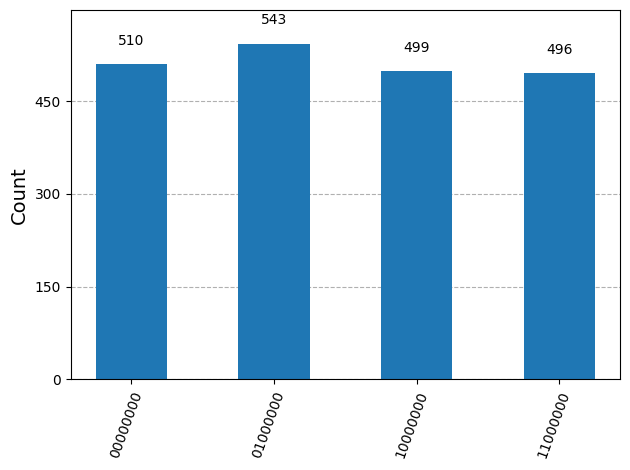

In [84]:
backend = AerSimulator()
tqc = transpile(qc, backend)
job = backend.run(tqc, shots = 2048)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

Real Quantum Hardware

In [16]:
load_dotenv(override=True)

api = os.getenv("API_KEY")

INSTANCE_CRN = os.getenv("CRN")

service = QiskitRuntimeService(
    channel="ibm_cloud",
    token=API_KEY,
    instance=INSTANCE_CRN,
)

print(service.backends())


python-dotenv could not parse statement starting at line 2


[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_marrakesh')>]


In [17]:
qBackendName = 'ibm_marrakesh'
qBackend = service.backend(qBackendName)
print(qBackend)

<IBMBackend('ibm_marrakesh')>


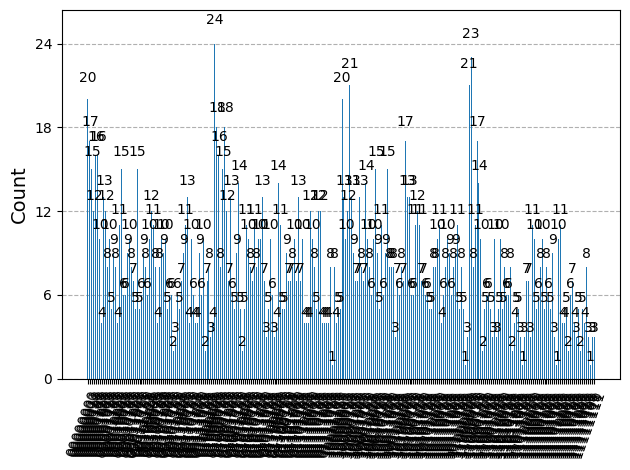

In [32]:
qtqc = transpile(qc, backend=qBackend)
sampler = Sampler(mode=qBackend)
job = sampler.run([(qtqc, None, 2048)]) 
result = job.result()
try:
    counts = result[0].data.meas.get_counts()
except AttributeError:
    counts = result[0].data.c.get_counts()

plot_histogram(counts)

In [35]:
sorted_counts = sorted(
    counts.items(),        
    key=lambda x: x[1],   
    reverse=True           
)
print(sorted_counts)

[('01000000', 24), ('11000001', 23), ('11000000', 21), ('10000100', 21), ('10000000', 20), ('00000000', 20), ('01000001', 18), ('01000101', 18), ('00000001', 17), ('10100000', 17), ('11000100', 17), ('00000101', 16), ('01000010', 16), ('00000100', 16), ('00011001', 15), ('01000100', 15), ('00010001', 15), ('10010111', 15), ('00000010', 15), ('10010001', 15), ('10001100', 14), ('01100000', 14), ('11000101', 14), ('01001100', 14), ('00110010', 13), ('01101010', 13), ('10000001', 13), ('10100010', 13), ('01011000', 13), ('01001000', 13), ('00001000', 13), ('10001001', 13), ('10000101', 13), ('10100001', 13), ('00001001', 12), ('01110100', 12), ('10100110', 12), ('00000011', 12), ('01110000', 12), ('10000011', 12), ('01110101', 12), ('00100000', 12), ('01000110', 12), ('10010100', 11), ('11100000', 11), ('01010000', 11), ('00110001', 11), ('10110001', 11), ('00010000', 11), ('10111010', 11), ('10100101', 11), ('11101110', 11), ('01010100', 11), ('01100001', 11), ('11000011', 11), ('0010000

As you can see, also the Quantum Hardware Run gives us similar and close results to our simulation in this case for this circuit

Analyze measurement results, as it peaks close to N*(j/r), J is an integer, N is the Control Bits number, in our case here it is 8

In [85]:
measured_int = int(max(counts, key=counts.get),2)
print(f"Measured int: {measured_int}")

if measured_int ==0:
    print("This is trivial case, Run it again!")
else:
    phase = measured_int/ 2**Qubits
    frac = Fraction(phase).limit_denominator(15)
    r = frac.denominator
    print(f"Period (r) = {r}")
    if r % 2 != 0:
        print("Period is odd try different A")
    else:
       p = gcd(int(2**(r/2) + 1), 15)
       q = gcd(int(2**(r/2) - 1), 15)

print(f"Finaly factors = {p} and {q}")

Measured int: 64
Period (r) = 4
Finaly factors = 5 and 3
